In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")

In [2]:
from pyTVDN import TVDNDetect
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import detrend
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import lfilter, firls, decimate
from tqdm import tqdm
from easydict import EasyDict as edict
from collections import Counter
import pickle
import rpy2.robjects as robj

%matplotlib inline

### Parameters

In [3]:
kappa = 1.53
lamb = 1e-6
r = 6
Lmin = 10
fct = 2

In [4]:
robj.r["load"](f"/home/huaqingj/MyResearch/TVDN/NeuroImgR1/data/dataMat_Nsim50_Chg3_rank{r}_len180.RData")

'datamatrix','truematrix','candlist0','U'


In [5]:
DetObjs = []
for i in tqdm(range(len(robj.r["datamatrix"]))):
    Ymat = np.array(robj.r["datamatrix"][i])
    DetRec = TVDNDetect(Ymat=Ymat, dataType="fMRI", MaxM=10, is_detrend=False,
                      saveDir=None, showProgress=False, Lmin=Lmin, lamb=lamb, kappa=kappa, r=r, fct=fct)
    DetRec()
    DetObjs.append(DetRec)

100%|██████████| 50/50 [03:10<00:00,  3.81s/it]


## Results 

In [6]:
d, n = DetObjs[0].Ymat.shape
cpts =  np.array(robj.r["candlist0"])[1:-1]
cpts = cpts.astype(int)

### Plots under the true number of change points

In [7]:
ecptss = [DetObj.finalRes.chgMat[len(cpts)-1, :len(cpts)] for DetObj in DetObjs]

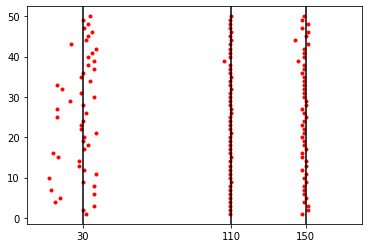

In [8]:
simuIdx = []
pos = []
for idx, chgpts in enumerate(ecptss):
    pos += list(chgpts)
    simuIdx += ([idx+1]*len(chgpts))
plt.plot(pos, simuIdx, ".", color="red")
plt.xlim([0, n])
plt.xticks(cpts, cpts)
for cpt in cpts:
    plt.axvline(cpt, color="black")

### Find the optimal kappa and get the plot under this kappa

In [9]:
kps = np.linspace(0, 4, 100)
numchgss = []
for DetObj in DetObjs:
    DetObj.TuningKappa(kps)
    numchgs = DetObj.numchgs
    numchgss.append(numchgs)

In [10]:
nChgArr = np.array(numchgss)
optIdx = np.argmin(np.abs(nChgArr.mean(axis=0) - 3))
optKp = kps[optIdx]
for DetObj in DetObjs:
    DetObj.UpdateEcpts(DetObj.numchgs[optIdx])

In [11]:
ecptss = [DetObj.ecpts for DetObj in DetObjs]

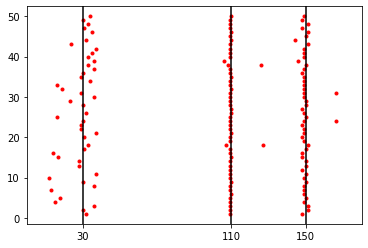

In [12]:
simuIdx = []
pos = []
for idx, chgpts in enumerate(ecptss):
    pos += list(chgpts)
    simuIdx += ([idx+1]*len(chgpts))
plt.plot(pos, simuIdx, ".", color="red")
plt.xlim([0, n])
plt.xticks(cpts, cpts)
for cpt in cpts:
    plt.axvline(cpt, color="black")

In [13]:
print(f"The kappa is {optKp:.3f}")

The kappa is 1.576


In [ ]:
with open(f"./results/newSimu_fct{fct*10:.0f}_rank{r:.0f}.pkl", "wb") as f:
    pickle.dump(DetObjs, f)

### Number of chgs vs BIC plot

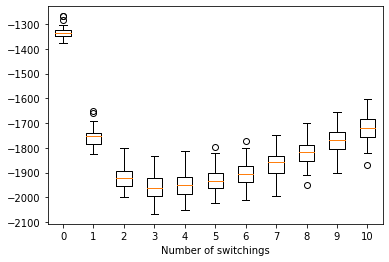

In [18]:
mbicss = [DetObj.finalRes.U for DetObj in DetObjs]
mbicss = np.array(mbicss)
plt.boxplot(mbicss)
plt.xlabel("Number of switchings")
_ = plt.xticks(list(range(1, 12)), list(range(11)))

### Ranks ve Error plot

In [28]:
DetObjss = edict()
DetObjss[f"rank{r}"] = DetObjs

In [34]:
for cR in [2, 4, 8, 10, 12, 14]:
    DetObjs = []
    for i in tqdm(range(len(robj.r["datamatrix"])), desc=f"Rank is {cR:.0f}"):
        Ymat = np.array(robj.r["datamatrix"][i])
        DetRec = TVDNDetect(Ymat=Ymat, dataType="fMRI", MaxM=10, is_detrend=False,
                          saveDir=None, showProgress=False, Lmin=Lmin, lamb=lamb, kappa=optKp, r=cR, fct=fct)
        DetRec()
        DetObjs.append(DetRec)
        
    DetObjss[f"rank{cR:.0f}"] = DetObjs
    with open(f"./results/newSimu_fct{fct*10:.0f}_rank{cR:.0f}.pkl", "wb") as f:
        pickle.dump(DetObjs, f)

Rank is 14: 100%|██████████| 50/50 [05:07<00:00,  5.97s/it]


### Obtain the errors under each rank

In [42]:
Errss = []
Ranks = np.array([2, 4, 6, 8, 10, 12, 14])
for cR in Ranks:
    Errs = [DetObj.GetCurMSE() for DetObj in DetObjss[f"rank{cR:.0f}"]]
    Errss.append(Errs)

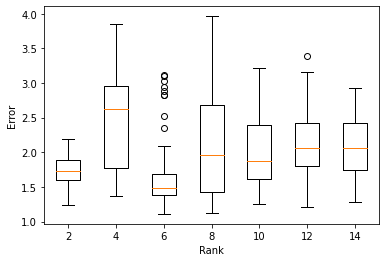

In [49]:
ErrssArr = np.array(Errss).T
plt.boxplot(ErrssArr)
plt.xlabel("Rank")
plt.ylabel("Error")
_ = plt.xticks(list(range(1, 1+len(Ranks))), Ranks)

In [50]:
ErrssArr.mean(axis=0)

array([1.73667099, 2.46738728, 1.71305522, 2.11924544, 2.014332  ,
       2.0913411 , 2.06329574])

## Varying number of knots for Bspline

In [11]:
nKnotss = [60, 90, 120, 150, 180]

In [12]:
kappa = 1.576
lamb = 1e-6
r = 6
Lmin = 10
fct = 2

In [13]:
for nKnots in nKnotss:
    DetObjs = []
    for i in tqdm(range(len(robj.r["datamatrix"])), desc=f"The nKnots is {nKnots:.0f}"):
        Ymat = np.array(robj.r["datamatrix"][i])
        DetRec = TVDNDetect(Ymat=Ymat, dataType="fMRI", MaxM=10, is_detrend=False,
                          saveDir=None, showProgress=False, Lmin=Lmin, lamb=lamb, kappa=kappa, r=r, fct=fct, nKnots=nKnots)
        DetRec()
        DetObjs.append(DetRec)
        
    with open(f"./results/newSimuKnots_nKnots{nKnots:.0f}_rank{r:.0f}.pkl", "wb") as f:
        pickle.dump(DetObjs, f)

The nKnots is 180: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it]


In [14]:
ErrsKnots = []
for nKnots in nKnotss:
    with open(f"./results/newSimuKnots_nKnots{nKnots:.0f}_rank{r:.0f}.pkl", "rb") as f:
        DetObjs = pickle.load(f)
    Errs = [DetObj.GetCurMSE() for DetObj in DetObjs]
    ErrsKnots.append(Errs)

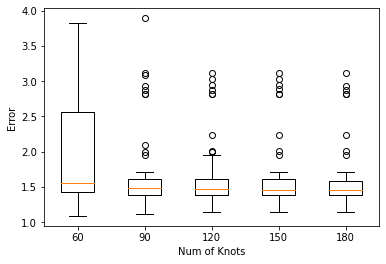

In [17]:
ErrsKnotsArr = np.array(ErrsKnots).T
plt.boxplot(ErrsKnotsArr)
plt.xlabel("Num of Knots")
plt.ylabel("Error")
_ = plt.xticks(list(range(1, 1+len(nKnotss))), nKnotss)

In [16]:
ErrsKnotsArr.mean(axis=0)

array([1.90207996, 1.6983542 , 1.65762771, 1.64647233, 1.6153882 ])